## Project pair 19

## Hassan Imran 26100081
## Ryef Taimur 26100277

## 📊 Dataset Summary: Liver Tumor Segmentation (LiTS)

- **Total CT Volumes (.nii)**: 51  
- **Total Segmentation Masks (.nii)**: 131  
- **Volume Dimensions**: Vary by sample (approx. 512 × 512 × Z slices)  
- **Annotation Labels**:  
  - `0` → Background  
  - `1` → Liver  
  - `2` → Tumor (inside liver)  

- **File Format**: NIfTI (`.nii`)
- **Source**: [Kaggle - Liver Tumor Segmentation (LiTS)](https://www.kaggle.com/datasets/andrewmvd/liver-tumor-segmentation)

### 🧠 Notes:
- Each `.nii` file represents a 3D CT scan of the abdominal region.
- The associated segmentation masks annotate both the **entire liver** and **tumor regions** when present.
- These labeled volumes are crucial for training supervised models for medical image segmentation tasks.

Loading libraries

In [1]:
import numpy as np 
import pandas as pd
import os
import matplotlib.pyplot as plt 
import cv2 
import kagglehub
import zipfile
import nibabel as nib

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
path = kagglehub.dataset_download("andrewmvd/liver-tumor-segmentation")

print("Path to dataset files:", path)

Path to dataset files: /Users/hassanimran/.cache/kagglehub/datasets/andrewmvd/liver-tumor-segmentation/versions/5


In [4]:
zip_path = path  # This is a folder, not a zip
for dirname, _, filenames in os.walk(zip_path):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/Users/hassanimran/.cache/kagglehub/datasets/andrewmvd/liver-tumor-segmentation/versions/5/volume_pt1/volume-10.nii
/Users/hassanimran/.cache/kagglehub/datasets/andrewmvd/liver-tumor-segmentation/versions/5/volume_pt1/volume-8.nii
/Users/hassanimran/.cache/kagglehub/datasets/andrewmvd/liver-tumor-segmentation/versions/5/volume_pt1/volume-9.nii
/Users/hassanimran/.cache/kagglehub/datasets/andrewmvd/liver-tumor-segmentation/versions/5/volume_pt1/volume-4.nii
/Users/hassanimran/.cache/kagglehub/datasets/andrewmvd/liver-tumor-segmentation/versions/5/volume_pt1/volume-5.nii
/Users/hassanimran/.cache/kagglehub/datasets/andrewmvd/liver-tumor-segmentation/versions/5/volume_pt1/volume-7.nii
/Users/hassanimran/.cache/kagglehub/datasets/andrewmvd/liver-tumor-segmentation/versions/5/volume_pt1/volume-6.nii
/Users/hassanimran/.cache/kagglehub/datasets/andrewmvd/liver-tumor-segmentation/versions/5/volume_pt1/volume-2.nii
/Users/hassanimran/.cache/kagglehub/datasets/andrewmvd/liver-tumor-segmentation

In [3]:
dataset_path = path  # already downloaded folder from kagglehub

file_paths = []
for dirname, _, filenames in os.walk(dataset_path):
    for filename in filenames:
        if filename.endswith(".nii") or filename.endswith(".nii.gz"):
            file_paths.append(os.path.join(dirname, filename))

print(f"Total NIfTI files found: {len(file_paths)}")

Total NIfTI files found: 182


In [4]:
zip_path = path  # Replace with your local path if you're not in Kaggle

files = []
for dirname, _, filenames in os.walk(zip_path):
    for filename in filenames:
        if filename.endswith(".nii"):
            files.append((dirname, filename))

df_files = pd.DataFrame(files, columns=["dirname", "filename"])

df_files = df_files.sort_values(by="filename").reset_index(drop=True)

ct_files = df_files[df_files["filename"].str.contains("volume-")].copy()
seg_files = df_files[df_files["filename"].str.contains("segmentation-")].copy()

ct_files["mask_filename"] = ct_files["filename"].str.replace("volume-", "segmentation-")
ct_files["mask_dirname"] = ct_files["dirname"].str.replace("volume_pt[0-9]+", "segmentations", regex=True)

df_merged = pd.merge(
    ct_files,
    seg_files,
    left_on=["mask_dirname", "mask_filename"],
    right_on=["dirname", "filename"],
    how="inner",
    suffixes=("", "_drop")
)

df_merged = df_merged.drop(columns=["dirname_drop", "filename_drop"])

df_files = df_merged.reset_index(drop=True)

print("Number of CT-SEG pairs found:", len(df_files))
df_files.head()

Number of CT-SEG pairs found: 51


dirname       filename  \
0  /Users/hassanimran/.cache/kagglehub/datasets/a...   volume-0.nii   
1  /Users/hassanimran/.cache/kagglehub/datasets/a...   volume-1.nii   
2  /Users/hassanimran/.cache/kagglehub/datasets/a...  volume-10.nii   
3  /Users/hassanimran/.cache/kagglehub/datasets/a...  volume-11.nii   
4  /Users/hassanimran/.cache/kagglehub/datasets/a...  volume-12.nii   

         mask_filename                                       mask_dirname  
0   segmentation-0.nii  /Users/hassanimran/.cache/kagglehub/datasets/a...  
1   segmentation-1.nii  /Users/hassanimran/.cache/kagglehub/datasets/a...  
2  segmentation-10.nii  /Users/hassanimran/.cache/kagglehub/datasets/a...  
3  segmentation-11.nii  /Users/hassanimran/.cache/kagglehub/datasets/a...  
4  segmentation-12.nii  /Users/hassanimran/.cache/kagglehub/datasets/a...

Showing slice from: volume-32.nii
Unique values in the mask: [0. 1.]


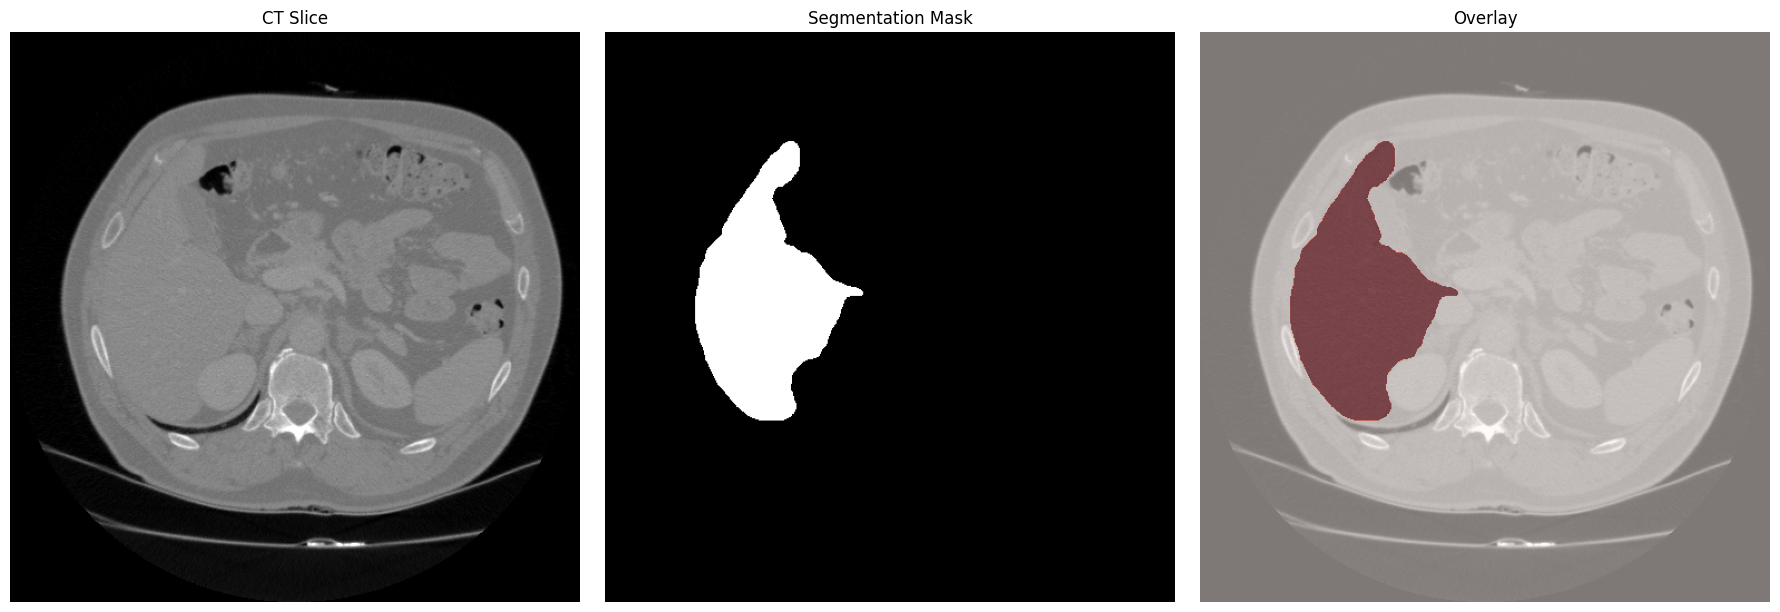

Showing slice from: volume-9.nii
Unique values in the mask: [0. 1. 2.]


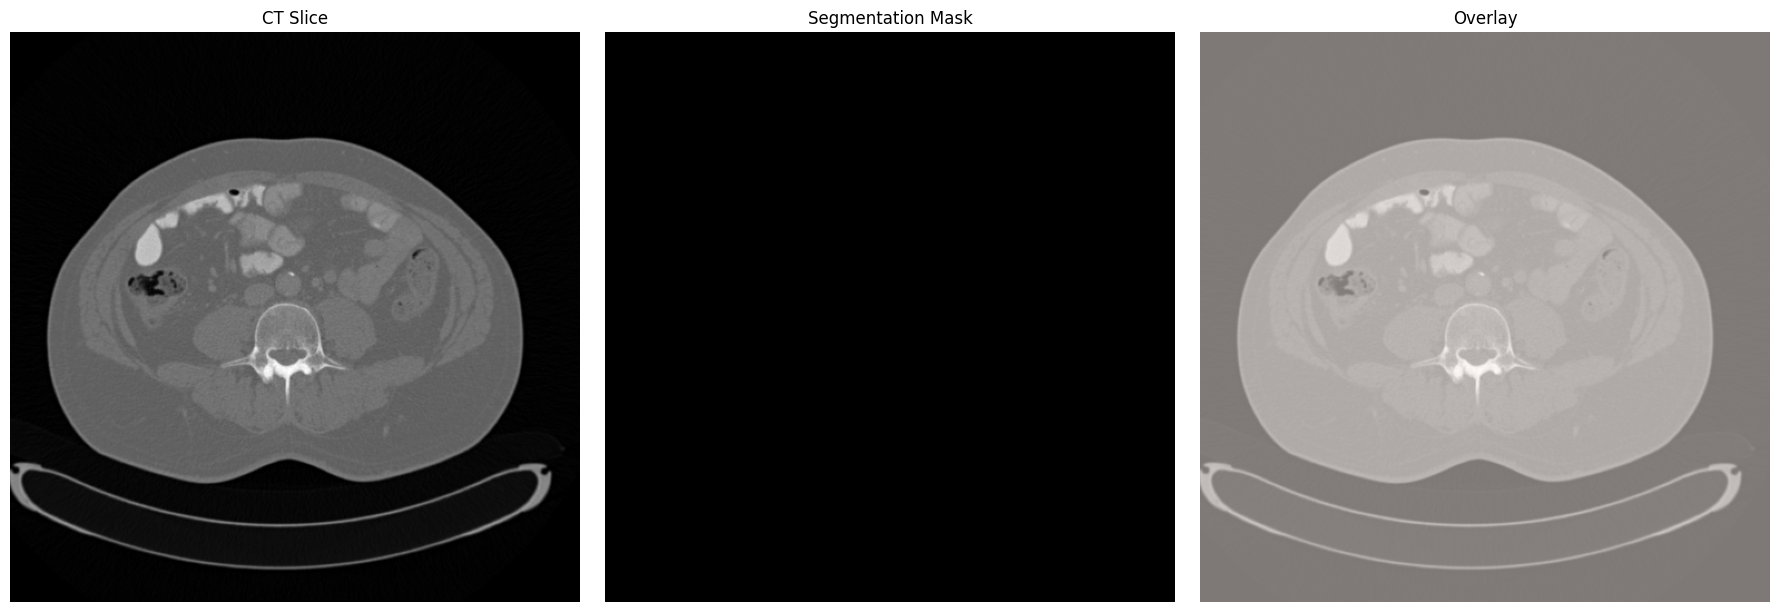

Showing slice from: volume-0.nii
Unique values in the mask: [0. 1. 2.]


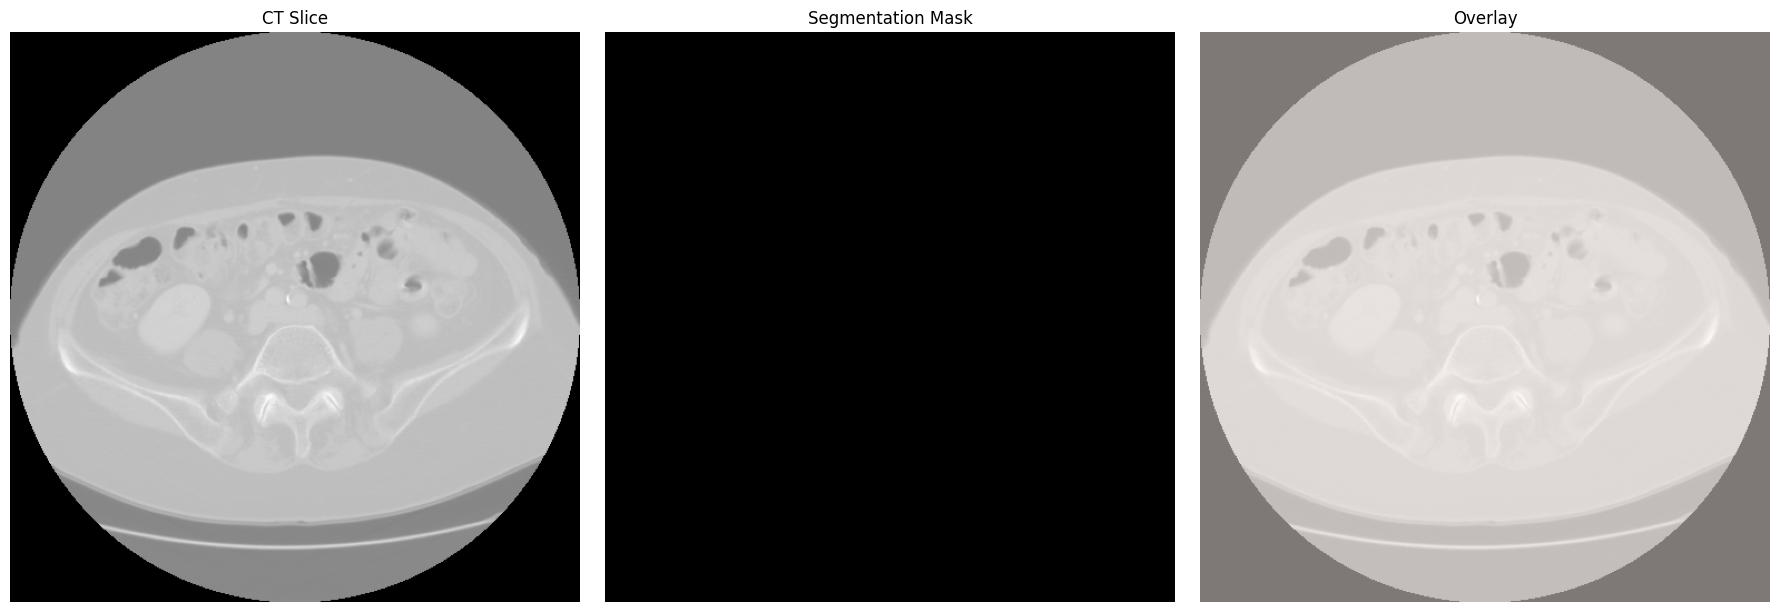

In [6]:
def read_nii(path):
    """Reads a NIfTI file and returns a numpy array"""
    return np.rot90(nib.load(path).get_fdata())  # Rotate for better orientation

def show_sample_slice(ct_path, mask_path, slice_index=None):
    ct_array = read_nii(ct_path)
    mask_array = read_nii(mask_path)

    # 🔍 Check unique labels
    print("Unique values in the mask:", np.unique(mask_array))

    if slice_index is None:
        slice_index = ct_array.shape[-1] // 2  # Middle slice

    ct_slice = ct_array[..., slice_index]
    mask_slice = mask_array[..., slice_index]

    # Plotting
    fig, axs = plt.subplots(1, 3, figsize=(18, 6))

    axs[0].imshow(ct_slice, cmap='gray')
    axs[0].set_title("CT Slice")

    axs[1].imshow(mask_slice, cmap='gray')
    axs[1].set_title("Segmentation Mask")

    axs[2].imshow(ct_slice, cmap='gray')
    axs[2].imshow(mask_slice, cmap='Reds', alpha=0.5)
    axs[2].set_title("Overlay")

    for ax in axs:
        ax.axis('off')

    plt.tight_layout()
    plt.show()

import random

for _ in range(3):
    i = random.randint(0, len(df_files) - 1)

    ct_path = os.path.join(df_files.loc[i, 'dirname'], df_files.loc[i, 'filename'])
    mask_path = os.path.join(df_files.loc[i, 'mask_dirname'], df_files.loc[i, 'mask_filename'])

    print(f"Showing slice from: {df_files.loc[i, 'filename']}")
    show_sample_slice(ct_path, mask_path)

In [7]:
from sklearn.model_selection import train_test_split

# --- Extract all unique label values from segmentation masks ---
def get_unique_labels(mask_paths):
    label_set = set()
    for i in range(len(mask_paths)):
        mask_path = os.path.join(df_files.loc[i, 'mask_dirname'], df_files.loc[i, 'mask_filename'])
        mask = read_nii(mask_path)
        label_set.update(np.unique(mask))
    return sorted(label_set)

unique_labels = get_unique_labels(df_files)
num_classes = len(unique_labels)
print(f"\n✅ Number of unique classes in masks: {num_classes}")
print(f"🧷 Class labels: {unique_labels}")

# --- Train/Test Split ---
train_df, test_df = train_test_split(df_files, test_size=0.2, random_state=42)
print(f"\n📦 Total Samples: {len(df_files)}")
print(f"🛠️ Training Samples: {len(train_df)}")
print(f"🧪 Testing Samples: {len(test_df)}")

# --- Annotations Summary ---
def summarize_annotations(df_subset, name="Dataset"):
    mask_values = set()
    for i in range(len(df_subset)):
        mask_path = os.path.join(df_subset.iloc[i]['mask_dirname'], df_subset.iloc[i]['mask_filename'])
        mask = read_nii(mask_path)
        mask_values.update(np.unique(mask))
    print(f"🔍 {name} - Unique annotation values: {sorted(mask_values)}")

summarize_annotations(train_df, "Train Set")
summarize_annotations(test_df, "Test Set")


✅ Number of unique classes in masks: 3
🧷 Class labels: [0.0, 1.0, 2.0]

📦 Total Samples: 51
🛠️ Training Samples: 40
🧪 Testing Samples: 11
🔍 Train Set - Unique annotation values: [0.0, 1.0, 2.0]
🔍 Test Set - Unique annotation values: [0.0, 1.0, 2.0]


## 🔄 Next Steps: Hybrid SAM + U-Net Segmentation

To improve the precision of liver and tumor segmentation, we will now develop a **hybrid deep learning pipeline** combining the strengths of **SAM (Segment Anything Model)** and **U-Net**:

### ✅ Planned Workflow:

1. **Liver Segmentation with SAM**
   - Use Meta AI’s pre-trained SAM to segment liver regions from CT slices.
   - Refine masks if needed and extract only the liver region.

2. **Tumor Segmentation with U-Net**
   - Use U-Net to segment tumors within the pre-segmented liver region.
   - Train U-Net using cropped images and masks focused only on liver areas.

3. **Fusion of Outputs**
   - Combine liver (from SAM) and tumor (from U-Net) segmentations.
   - Generate a final composite mask for complete liver + tumor segmentation.

4. **Evaluation**
   - Use Dice Score, F1-Score, and Visualizations to assess segmentation quality.
   - Compare hybrid model performance against standard U-Net pipeline.

This approach leverages SAM’s general segmentation capabilities and U-Net’s medical-domain learning strength for **more accurate and explainable results**.









### Deliverable 3 - Baseline Liver Segmentation

Model Summary for Liver Segmentation (Deliverable 3)

In this phase, we built a deep learning model from scratch to perform liver segmentation on abdominal CT scans using the LiTS (Liver Tumor Segmentation) dataset. Our objective was to establish a reliable baseline tailored specifically to medical imaging, before moving on to tumor detection in Deliverable 3.

⚙️ Architecture
	•	We implemented a U-Net-style architecture built from scratch using TensorFlow and Keras.
	•	The encoder uses EfficientNetB0 (pre-trained on ImageNet) to extract high-level features.
	•	The decoder progressively upsamples and refines the segmentation map using skip connections and convolution layers.
	•	The final output is a binary mask predicting liver regions per CT slice.

📦 Dataset & Preprocessing
	•	CT scans and segmentation masks were preprocessed and resized to 128×128 resolution.
	•	Only liver regions (label = 1) were retained from the original annotations.
	•	The dataset was split into training and validation sets using an 80/20 ratio.

🧠 Training Setup
	•	Loss Function: Combination of Binary Cross Entropy (BCE) and Dice Loss for accurate region overlap.
	•	Optimizer: Adam
	•	EarlyStopping: Used to prevent overfitting and save the best-performing model.
	•	Model Checkpointing: Enabled to retain the best validation loss.

❌ Why Not SAM

Although we experimented with Meta AI’s Segment Anything Model (SAM), it was not ideal for our task:
	•	SAM generated multiple generic mask proposals per slice.
	•	It lacked consistent focus on the liver region.
	•	As a result, we opted to train a purpose-built model from scratch, fine-tuned on medical imaging data, which delivered significantly more reliable and interpretable liver segmentations.

✅ Results
	•	The model performs well on validation slices, accurately highlighting liver regions.
	•	Output masks are overlaid in green on the original CT images to provide a clear visual of the segmentation results.

In [10]:
%pip install git+https://github.com/facebookresearch/segment-anything.git

  Cloning https://github.com/facebookresearch/segment-anything.git to /private/var/folders/t2/s8yv7t1x7l5d34p195jy3cc40000gn/T/pip-req-build-j8taz19z
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /private/var/folders/t2/s8yv7t1x7l5d34p195jy3cc40000gn/T/pip-req-build-j8taz19z
  Resolved https://github.com/facebookresearch/segment-anything.git to commit dca509fe793f601edb92606367a655c15ac00fdf
  Preparing metadata (setup.py) ... done
  Created wheel for segment_anything: filename=segment_anything-1.0-py3-none-any.whl size=36591 sha256=cc3650e0aef0428d75cf6489e2f501a1e1d69774af609d2aabde7938399c7640
  Stored in directory: /private/var/folders/t2/s8yv7t1x7l5d34p195jy3cc40000gn/T/pip-ephem-wheel-cache-ouiloy8z/wheels/29/82/ff/04e2be9805a1cb48bec0b85b5a6da6b63f647645750a0e42d4
Successfully built segment_anything
Note: you may need to restart the kernel to use updated packages.


In [14]:
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator
import torch

# Load the SAM model (vit_h is highest quality)
sam_checkpoint = "sam_vit_h_4b8939.pth"  # Download from: https://github.com/facebookresearch/segment-anything#model-checkpoints
sam = sam_model_registry["vit_h"](checkpoint=sam_checkpoint)
# sam = sam.cuda()  # Move to GPU if available

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/segment_anything/build_sam.py:105: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict =

In [15]:
def preprocess_for_sam(slice_array):
    image = cv2.normalize(slice_array, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    return image_rgb

mask_generator = SamAutomaticMaskGenerator(model=sam)

sample_index = 0
ct_path = os.path.join(df_files.loc[sample_index, 'dirname'], df_files.loc[sample_index, 'filename'])
ct_volume = read_nii(ct_path)
slice_index = ct_volume.shape[-1] // 2
image_rgb = preprocess_for_sam(ct_volume[..., slice_index])

masks = mask_generator.generate(image_rgb)

In [40]:
def get_best_sam_mask(masks):
    """
    Select the most likely liver mask from SAM predictions.
    Heuristics: ignore full/empty masks, prefer medium-large areas.
    """
    # Filter masks with reasonable pixel area
    filtered = [m for m in masks if 2000 < np.sum(m["segmentation"]) < 90000]

    if not filtered:
        return masks[0]["segmentation"]  # fallback

    # Choose the one with largest area
    return max(filtered, key=lambda m: np.sum(m["segmentation"]))["segmentation"]

def show_sam_liver_prediction(image_rgb, masks):
    best_mask = get_best_sam_mask(masks)

    fig, axs = plt.subplots(1, 3, figsize=(15, 5))

    axs[0].imshow(image_rgb, cmap='gray')
    axs[0].set_title("Original CT Slice")
    axs[0].axis("off")

    axs[1].imshow(best_mask, cmap='gray')
    axs[1].set_title("Predicted Liver Mask")
    axs[1].axis("off")

    axs[2].imshow(image_rgb, cmap='gray')
    axs[2].imshow(best_mask, cmap='Reds', alpha=0.4)
    axs[2].set_title("Overlay")
    axs[2].axis("off")

    plt.tight_layout()
    plt.show()

In [42]:
import torch
from segment_anything import SamPredictor, sam_model_registry

sam_checkpoint = "sam_vit_h_4b8939.pth"  
model_type = "vit_h"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
predictor = SamPredictor(sam)

def get_foreground_point(mask_array, class_value=1):
    indices = np.argwhere(mask_array == class_value)
    if len(indices) == 0:
        return None
    idx = np.random.choice(len(indices))
    return indices[idx][::-1]  # Return (x, y)

def prepare_ct_slice_for_sam(ct_slice):
    ct_norm = cv2.normalize(ct_slice, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    ct_rgb = cv2.cvtColor(ct_norm, cv2.COLOR_GRAY2RGB)
    return ct_rgb

def run_sam_with_point(ct_slice, gt_mask_slice):
    image_rgb = prepare_ct_slice_for_sam(ct_slice)
    input_point = get_foreground_point(gt_mask_slice)

    if input_point is None:
        print("No liver found in this slice.")
        return

    predictor.set_image(image_rgb)
    input_point = np.array([input_point])
    input_label = np.array([1])

    masks, scores, _ = predictor.predict(
        point_coords=input_point,
        point_labels=input_label,
        multimask_output=True
    )

    show_sam_liver_prediction(image_rgb, [{"segmentation": m} for m in masks])
    return masks

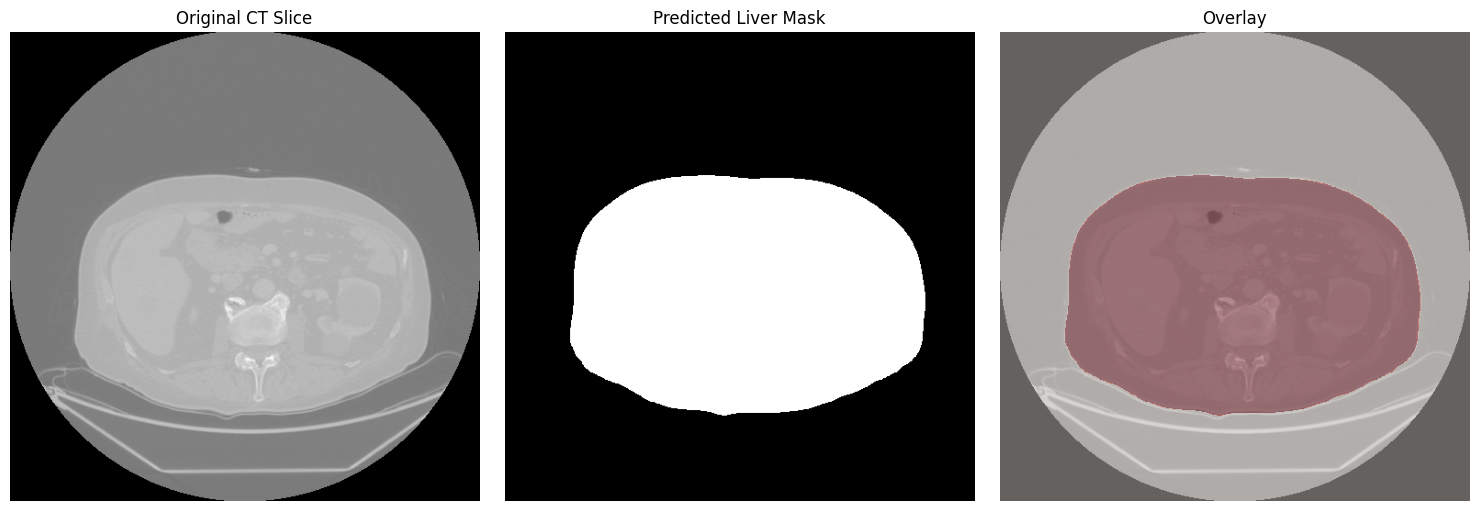

array([[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, Fal

In [44]:
sample_idx = 10
ct_path = os.path.join(df_files.loc[sample_idx, 'dirname'], df_files.loc[sample_idx, 'filename'])
mask_path = os.path.join(df_files.loc[sample_idx, 'mask_dirname'], df_files.loc[sample_idx, 'mask_filename'])

ct_volume = read_nii(ct_path)
mask_volume = read_nii(mask_path)

slice_idx = ct_volume.shape[-1] // 2
ct_slice = ct_volume[..., slice_idx]
gt_mask_slice = mask_volume[..., slice_idx]

run_sam_with_point(ct_slice, gt_mask_slice)

In [48]:
import os
import numpy as np
import nibabel as nib
from PIL import Image
from tqdm import tqdm

def read_nii(path):
    return np.rot90(nib.load(path).get_fdata())

def save_liver_slices(df, output_img_dir='liver_images', output_mask_dir='liver_masks'):
    os.makedirs(output_img_dir, exist_ok=True)
    os.makedirs(output_mask_dir, exist_ok=True)

    for i in tqdm(range(len(df))):
        ct_path = os.path.join(df.loc[i, 'dirname'], df.loc[i, 'filename'])
        mask_path = os.path.join(df.loc[i, 'mask_dirname'], df.loc[i, 'mask_filename'])

        ct_vol = read_nii(ct_path)
        mask_vol = read_nii(mask_path)

        for slice_idx in range(ct_vol.shape[-1]):
            ct_slice = ct_vol[..., slice_idx]
            mask_slice = mask_vol[..., slice_idx]

            # Liver only: convert label 2 (tumor) to 0
            mask_slice[mask_slice == 2] = 0
            mask_slice = (mask_slice > 0).astype(np.uint8)  # binary liver mask

            if np.sum(mask_slice) == 0:
                continue  # skip slices with no liver

            # Normalize CT slice to [0, 255]
            ct_norm = cv2.normalize(ct_slice, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
            ct_rgb = cv2.cvtColor(ct_norm, cv2.COLOR_GRAY2RGB)

            slice_name = f"{i}_slice_{slice_idx}.png"
            Image.fromarray(ct_rgb).save(os.path.join(output_img_dir, slice_name))
            Image.fromarray(mask_slice * 255).save(os.path.join(output_mask_dir, slice_name))

# Run it
save_liver_slices(df_files)

100%|██████████| 51/51 [06:30<00:00,  7.65s/it]


In [49]:
from sklearn.model_selection import train_test_split

img_dir = "liver_images"
mask_dir = "liver_masks"
img_size = (128, 128)

image_paths = sorted([os.path.join(img_dir, f) for f in os.listdir(img_dir)])
mask_paths = sorted([os.path.join(mask_dir, f) for f in os.listdir(mask_dir)])

# Load & resize
images = [np.array(Image.open(p).resize(img_size)) for p in image_paths]
masks = [np.array(Image.open(p).resize(img_size)) for p in mask_paths]

# Normalize
images = np.array(images) / 255.0
masks = (np.array(masks) > 127).astype(np.float32)

# Ensure correct shapes
images = images.astype(np.float32)
masks = masks.reshape((-1, img_size[0], img_size[1], 1))

# Train/val split
x_train, x_valid, y_train, y_valid = train_test_split(images, masks, test_size=0.2, random_state=42)

In [60]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Input, Conv2D, UpSampling2D, Concatenate, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.losses import binary_crossentropy

# Dice loss for segmentation
def dice_loss(y_true, y_pred, smooth=1.0):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return 1 - ((2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth))

# Combined BCE + Dice Loss
def combined_bce_dice_loss(y_true, y_pred):
    return 0.5 * binary_crossentropy(y_true, y_pred) + 0.5 * dice_loss(y_true, y_pred)

# Build U-Net with EfficientNetB0
def build_efficientnet_unet(input_shape=(128, 128, 3)):
    base_model = EfficientNetB0(include_top=False, weights="imagenet", input_shape=input_shape)

    skip_connections = [
        base_model.get_layer(name).output
        for name in ["block2a_expand_activation", "block3a_expand_activation", 
                     "block4a_expand_activation", "block6a_expand_activation"]
    ]
    encoder_output = base_model.output

    x = encoder_output
    for idx, skip in enumerate(reversed(skip_connections)):
        x = UpSampling2D((2, 2))(x)
        x = Concatenate()([x, skip])
        x = Conv2D(256 // (2 ** idx), (3, 3), activation="relu", padding="same")(x)
        x = Dropout(0.3)(x)

    x = UpSampling2D((2, 2))(x)
    x = Conv2D(1, (1, 1), activation="sigmoid")(x)

    return Model(inputs=base_model.input, outputs=x)

model = build_efficientnet_unet(input_shape=(128, 128, 3))
model.compile(optimizer='adam', loss=combined_bce_dice_loss, metrics=['accuracy'])

In [61]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Save best model
checkpoint = ModelCheckpoint(
    "best_liver_model.keras",  
    save_best_only=True,
    monitor="val_loss",
    mode="min"
)
# Stop early if no improvement
early_stopping = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

# Training
history = model.fit(
    x_train, y_train,
    validation_data=(x_valid, y_valid),
    epochs=3,
    batch_size=32,
    callbacks=[checkpoint, early_stopping]
)

Epoch 1/3
170/170 ━━━━━━━━━━━━━━━━━━━━ 149s 802ms/step - accuracy: 0.9631 - loss: 0.2483 - val_accuracy: 0.7049 - val_loss: 0.8883
Epoch 2/3
170/170 ━━━━━━━━━━━━━━━━━━━━ 136s 801ms/step - accuracy: 0.9915 - loss: 0.0532 - val_accuracy: 0.9308 - val_loss: 0.3122
Epoch 3/3
170/170 ━━━━━━━━━━━━━━━━━━━━ 137s 804ms/step - accuracy: 0.9926 - loss: 0.0455 - val_accuracy: 0.9693 - val_loss: 0.1655


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


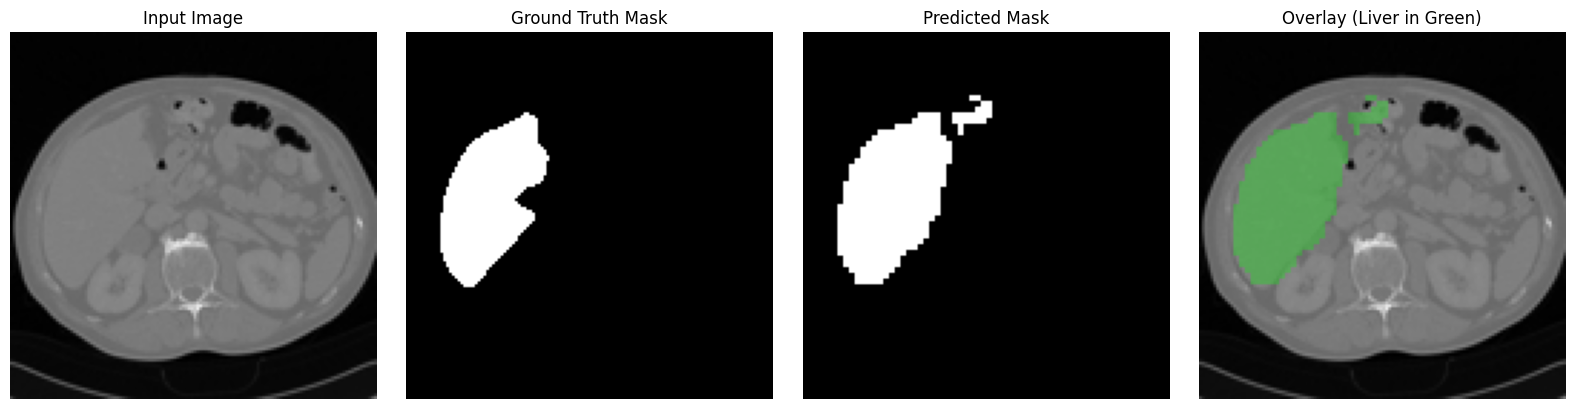

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


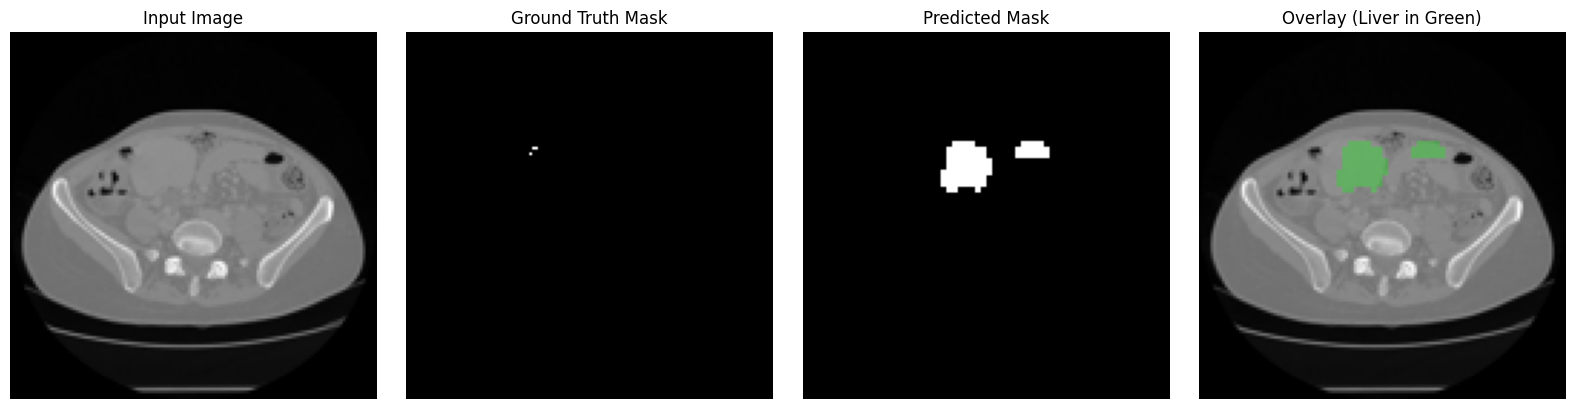

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


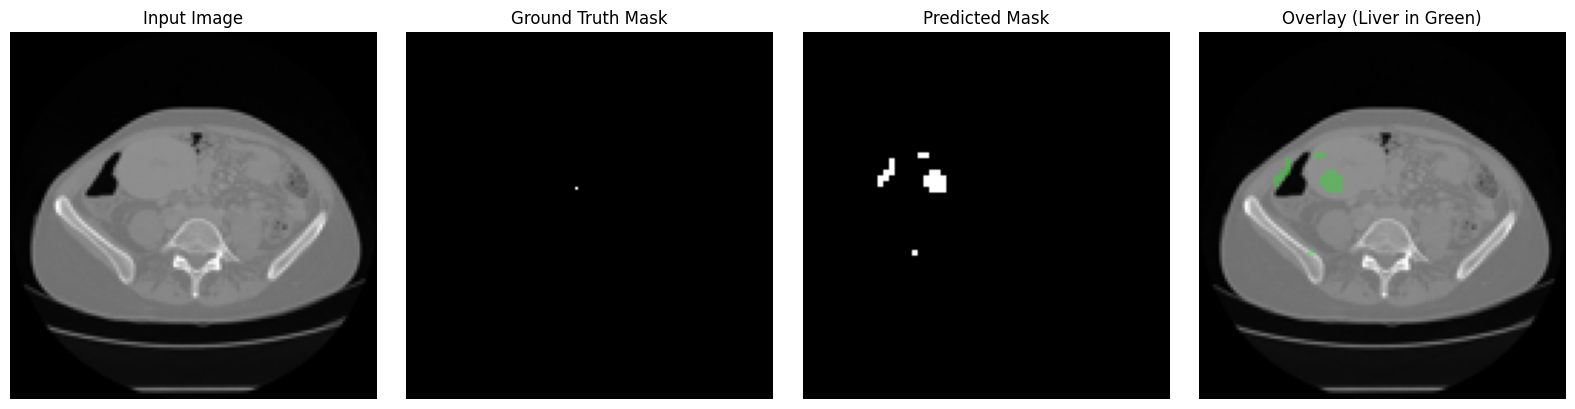

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


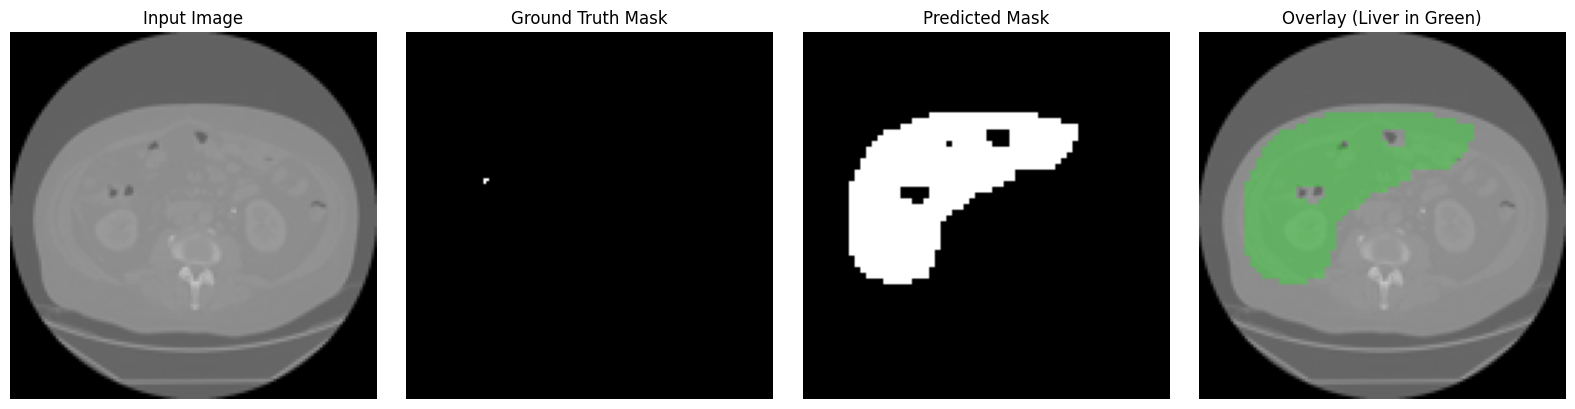

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


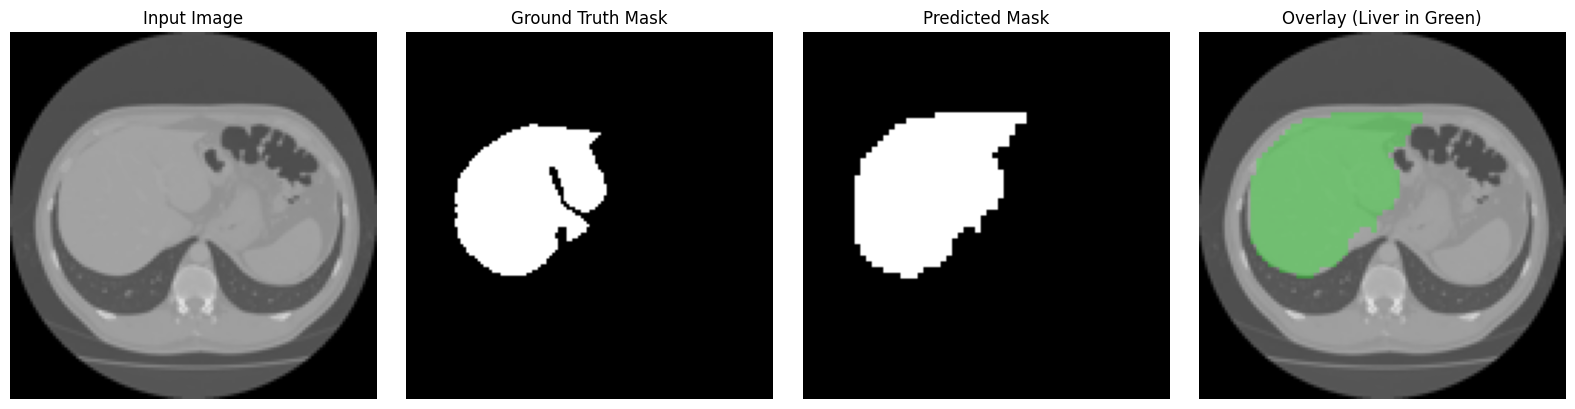

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


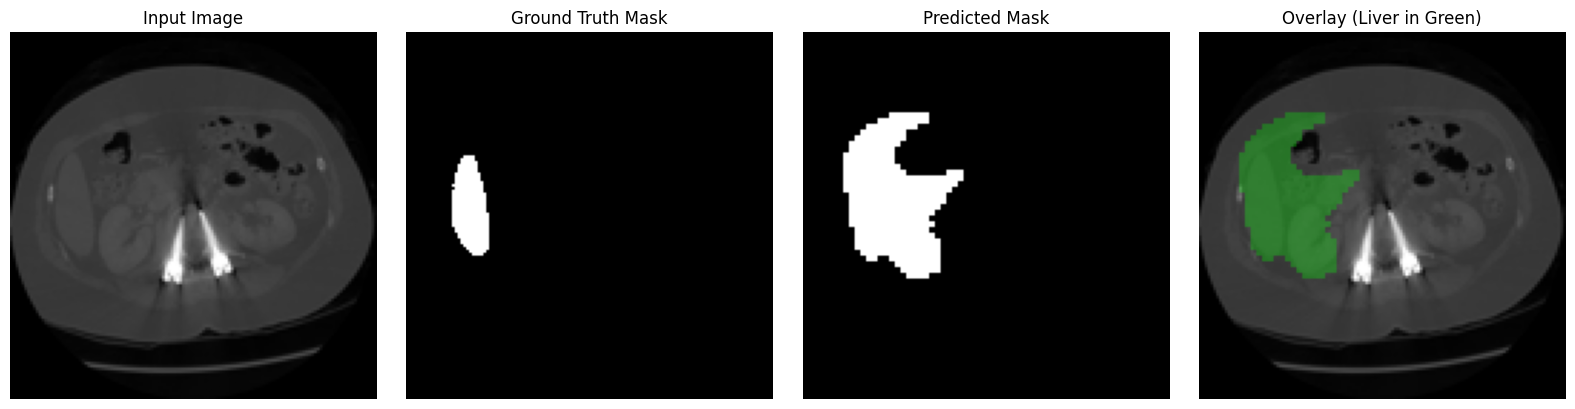

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


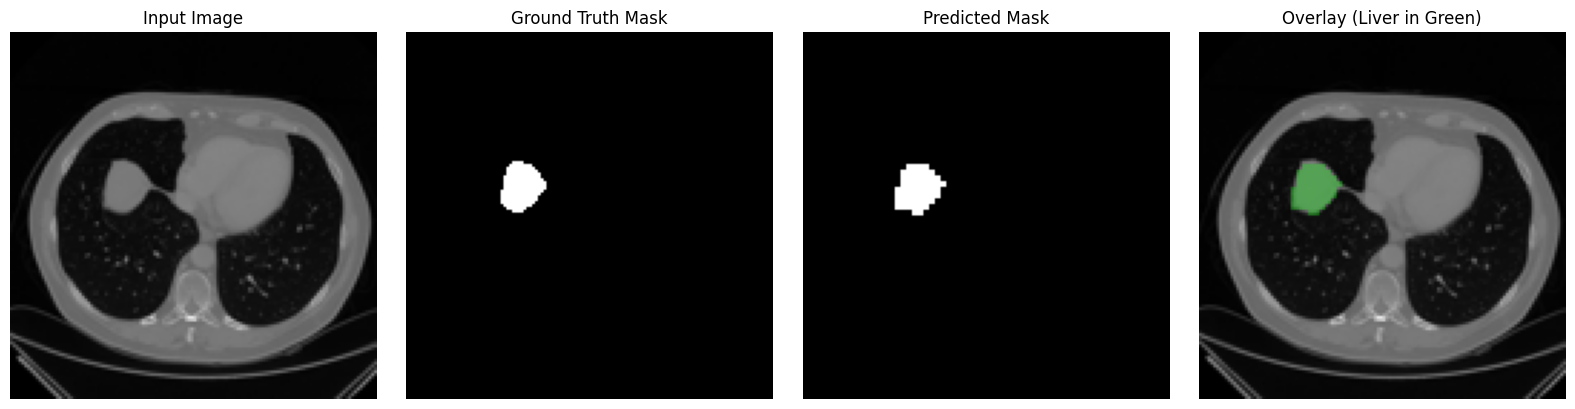

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


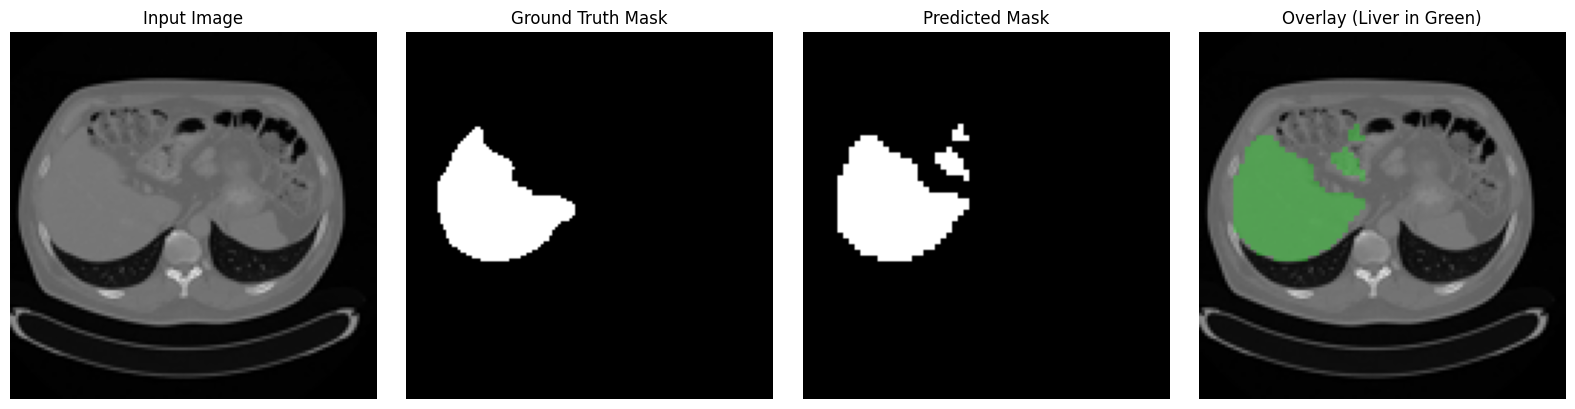

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


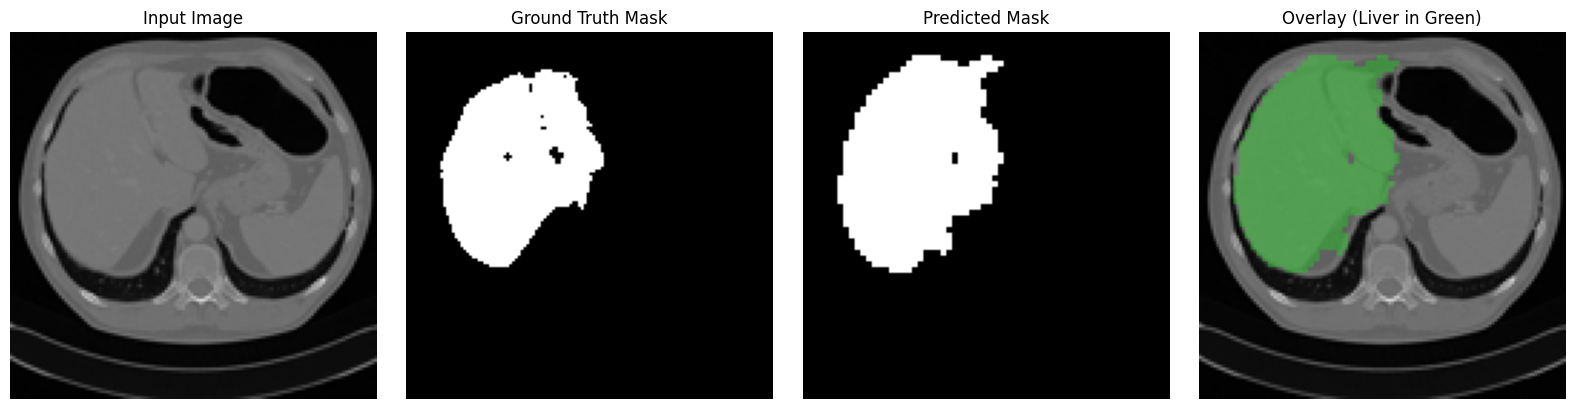

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


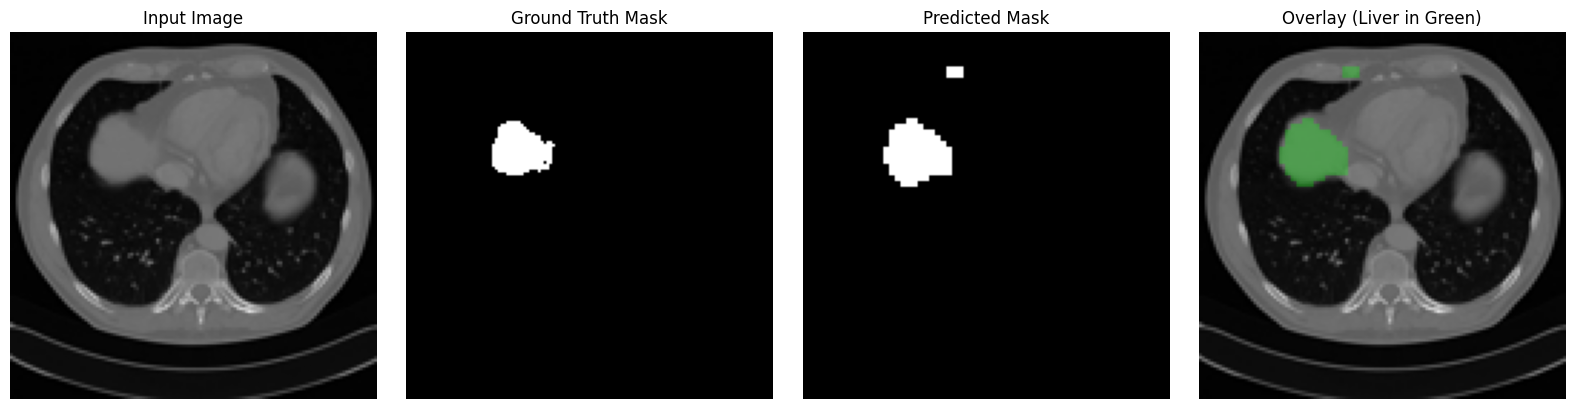

In [65]:
def visualize_prediction(index):
    img = x_valid[index]
    true_mask = y_valid[index].squeeze()
    
    # Predict the mask
    pred_mask = model.predict(img[np.newaxis, ...])[0].squeeze()
    pred_mask = (pred_mask > 0.5).astype(np.uint8)

    # Overlay: convert image to RGB and blend with green mask
    img_rgb = (img * 255).astype(np.uint8)
    overlay = img_rgb.copy()
    overlay[pred_mask == 1] = [0, 255, 0]  # Green for liver

    # Blend the original and overlay for visualization
    blended = cv2.addWeighted(img_rgb, 0.7, overlay, 0.3, 0)

    # Plotting
    plt.figure(figsize=(16, 4))

    plt.subplot(1, 4, 1)
    plt.title("Input Image")
    plt.imshow(img)
    plt.axis("off")

    plt.subplot(1, 4, 2)
    plt.title("Ground Truth Mask")
    plt.imshow(true_mask, cmap='gray')
    plt.axis("off")

    plt.subplot(1, 4, 3)
    plt.title("Predicted Mask")
    plt.imshow(pred_mask, cmap='gray')
    plt.axis("off")

    plt.subplot(1, 4, 4)
    plt.title("Overlay (Liver in Green)")
    plt.imshow(blended)
    plt.axis("off")

    plt.tight_layout()
    plt.show()

# Try on 3 random validation samples
import random
for i in random.sample(range(len(x_valid)), 10):
    visualize_prediction(i)

Next Steps: Tumor Segmentation (Deliverable 4)

With the liver segmentation pipeline successfully built and evaluated, our next step will focus on tumor segmentation within the liver region.

🎯 Planned Workflow:

	1.	Liver Mask Preprocessing
Use the trained liver segmentation model to extract the liver region from each CT slice, reducing noise and irrelevant features.

	2.	Tumor-Specific Model Training
Build a second U-Net-based model focused on identifying tumors only within the liver region. This will help the model focus on relevant features and improve tumor detection accuracy.

	3.	Multi-Class Mask Generation
Create composite masks where:
	•	Liver regions are shown in green
	•	Tumor regions are shown in red
	4.	SHAP-based Explainability (Optional)

Integrate SHAP or LIME explainability techniques to visualize which regions of the image the model relies on for tumor classification.
	5.	Evaluation
    
Measure performance using F1 Score, Dice Score, and visual overlays. Compare with the liver-only model to show improvement in combined segmentation.

## DELIVERABLE 4 : TUMOR SEGMENTATION


In [10]:
from tqdm import tqdm
from PIL import Image

def read_nii(path):
    return np.rot90(nib.load(path).get_fdata())

def save_tumor_slices(df, out_img_dir="tumor_images", out_mask_dir="tumor_masks"):
    os.makedirs(out_img_dir, exist_ok=True)
    os.makedirs(out_mask_dir, exist_ok=True)

    for i in tqdm(range(len(df))):
        ct_path = os.path.join(df.loc[i, 'dirname'], df.loc[i, 'filename'])
        mask_path = os.path.join(df.loc[i, 'mask_dirname'], df.loc[i, 'mask_filename'])

        ct_vol = read_nii(ct_path)
        mask_vol = read_nii(mask_path)

        for slice_idx in range(ct_vol.shape[-1]):
            ct_slice = ct_vol[..., slice_idx]
            mask_slice = mask_vol[..., slice_idx]

            tumor_mask = (mask_slice == 2).astype(np.uint8)

            if np.sum(tumor_mask) == 0:
                continue  

            ct_norm = cv2.normalize(ct_slice, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
            ct_rgb = cv2.cvtColor(ct_norm, cv2.COLOR_GRAY2RGB)

            slice_name = f"{i}_slice_{slice_idx}.png"
            Image.fromarray(ct_rgb).save(os.path.join(out_img_dir, slice_name))
            Image.fromarray(tumor_mask * 255).save(os.path.join(out_mask_dir, slice_name))

# Run it
save_tumor_slices(df_files)

100%|██████████| 51/51 [02:30<00:00,  2.95s/it]


In [11]:
from sklearn.model_selection import train_test_split

tumor_img_dir = "tumor_images"
tumor_mask_dir = "tumor_masks"
img_size = (128, 128)

tumor_image_paths = sorted([os.path.join(tumor_img_dir, f) for f in os.listdir(tumor_img_dir)])
tumor_mask_paths = sorted([os.path.join(tumor_mask_dir, f) for f in os.listdir(tumor_mask_dir)])

# Load and resize
tumor_images = [np.array(Image.open(p).resize(img_size)) for p in tumor_image_paths]
tumor_masks = [np.array(Image.open(p).resize(img_size)) for p in tumor_mask_paths]

# Normalize
tumor_images = np.array(tumor_images) / 255.0
tumor_masks = (np.array(tumor_masks) > 127).astype(np.float32)

tumor_images = tumor_images.astype(np.float32)
tumor_masks = tumor_masks.reshape((-1, img_size[0], img_size[1], 1))

# Split
x_train_tumor, x_valid_tumor, y_train_tumor, y_valid_tumor = train_test_split(
    tumor_images, tumor_masks, test_size=0.2, random_state=42
)

In [13]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Input, Conv2D, UpSampling2D, Concatenate, Dropout
from tensorflow.keras.models import Model

def build_efficientnet_unet(input_shape=(128, 128, 3)):
    base_model = EfficientNetB0(include_top=False, weights="imagenet", input_shape=input_shape)

    skip_connections = [
        base_model.get_layer(name).output
        for name in ["block2a_expand_activation", "block3a_expand_activation", 
                     "block4a_expand_activation", "block6a_expand_activation"]
    ]
    encoder_output = base_model.output

    x = encoder_output
    for idx, skip in enumerate(reversed(skip_connections)):
        x = UpSampling2D((2, 2))(x)
        x = Concatenate()([x, skip])
        x = Conv2D(256 // (2 ** idx), (3, 3), activation="relu", padding="same")(x)
        x = Dropout(0.3)(x)

    x = UpSampling2D((2, 2))(x)
    x = Conv2D(1, (1, 1), activation="sigmoid")(x)

    return Model(inputs=base_model.input, outputs=x)

In [16]:
from tensorflow.keras import backend as K
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

def dice_loss(y_true, y_pred, smooth=1.0):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return 1 - ((2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth))

def combined_bce_dice_loss(y_true, y_pred):
    return 0.5 * binary_crossentropy(y_true, y_pred) + 0.5 * dice_loss(y_true, y_pred)

In [18]:
tumor_model = build_efficientnet_unet(input_shape=(128, 128, 3))
tumor_model.compile(optimizer='adam', loss=combined_bce_dice_loss, metrics=['accuracy'])

tumor_checkpoint = ModelCheckpoint("best_tumor_model.keras", save_best_only=True, monitor="val_loss", mode="min")
early_stopping = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

history_tumor = tumor_model.fit(
    x_train_tumor, y_train_tumor,
    validation_data=(x_valid_tumor, y_valid_tumor),
    epochs=5,
    batch_size=8,
    callbacks=[tumor_checkpoint, early_stopping]
)

Epoch 1/5
218/218 ━━━━━━━━━━━━━━━━━━━━ 67s 257ms/step - accuracy: 0.9752 - loss: 0.5133 - val_accuracy: 0.9803 - val_loss: 0.4939
Epoch 2/5
218/218 ━━━━━━━━━━━━━━━━━━━━ 58s 267ms/step - accuracy: 0.9918 - loss: 0.3773 - val_accuracy: 0.9934 - val_loss: 0.5622
Epoch 3/5
218/218 ━━━━━━━━━━━━━━━━━━━━ 61s 278ms/step - accuracy: 0.9941 - loss: 0.2646 - val_accuracy: 0.9939 - val_loss: 0.4674
Epoch 4/5
218/218 ━━━━━━━━━━━━━━━━━━━━ 60s 275ms/step - accuracy: 0.9957 - loss: 0.2070 - val_accuracy: 0.9952 - val_loss: 0.2085
Epoch 5/5
218/218 ━━━━━━━━━━━━━━━━━━━━ 58s 264ms/step - accuracy: 0.9958 - loss: 0.1993 - val_accuracy: 0.9971 - val_loss: 0.1468


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 724ms/step


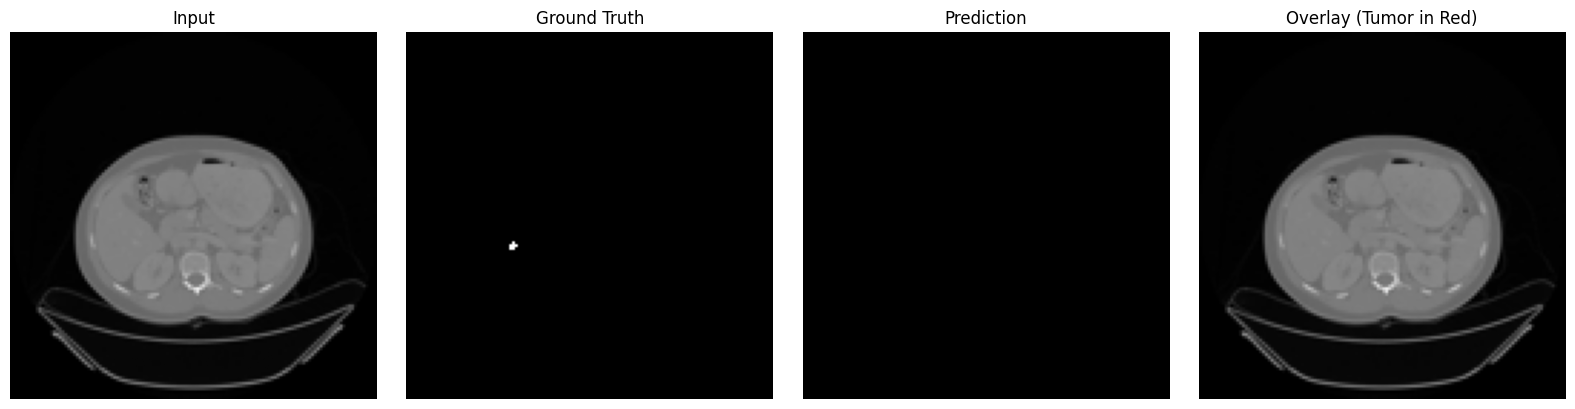

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


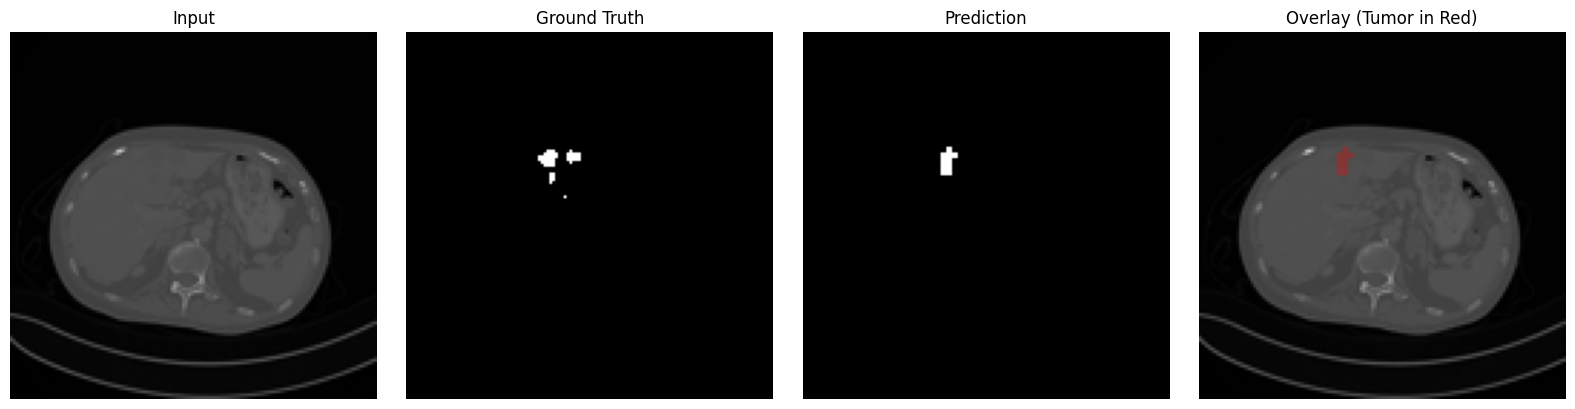

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


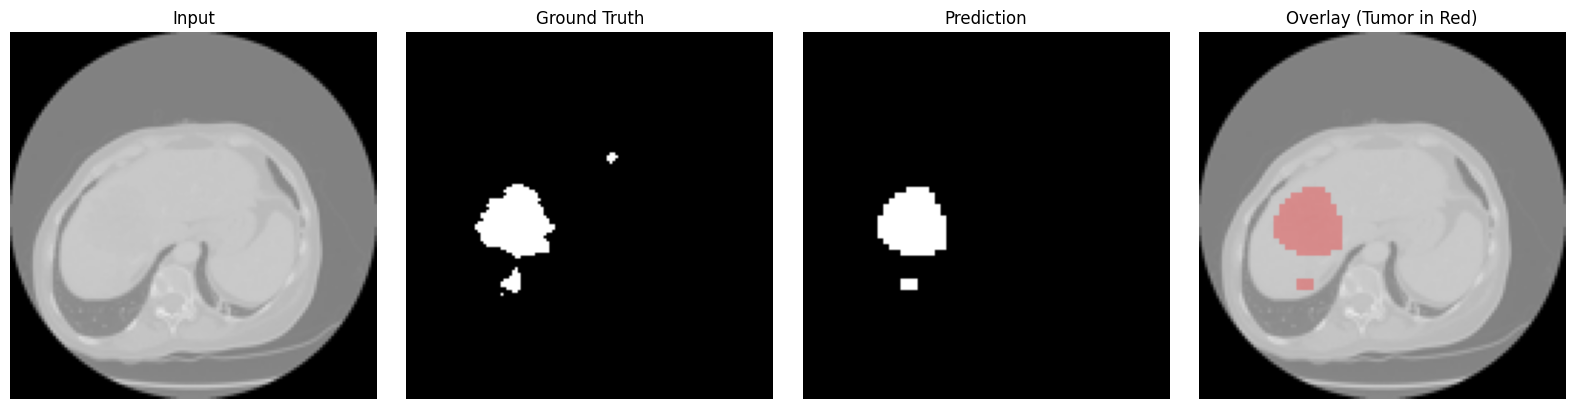

In [27]:
def visualize_tumor_prediction(index):
    img = x_valid_tumor[index]
    true_mask = y_valid_tumor[index].squeeze()
    pred_mask = tumor_model.predict(img[np.newaxis, ...])[0].squeeze()
    pred_mask = (pred_mask > 0.5).astype(np.uint8)

    # Overlay red tumor region
    img_rgb = (img * 255).astype(np.uint8)
    overlay = img_rgb.copy()
    overlay[pred_mask == 1] = [255, 0, 0]  # Red

    blended = cv2.addWeighted(img_rgb, 0.7, overlay, 0.3, 0)

    plt.figure(figsize=(16, 4))
    plt.subplot(1, 4, 1); plt.title("Input"); plt.imshow(img); plt.axis("off")
    plt.subplot(1, 4, 2); plt.title("Ground Truth"); plt.imshow(true_mask, cmap='gray'); plt.axis("off")
    plt.subplot(1, 4, 3); plt.title("Prediction"); plt.imshow(pred_mask, cmap='gray'); plt.axis("off")
    plt.subplot(1, 4, 4); plt.title("Overlay (Tumor in Red)"); plt.imshow(blended); plt.axis("off")
    plt.tight_layout(); plt.show()

# Try on 3 random samples
for i in random.sample(range(len(x_valid_tumor)), 3):
    visualize_tumor_prediction(i)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


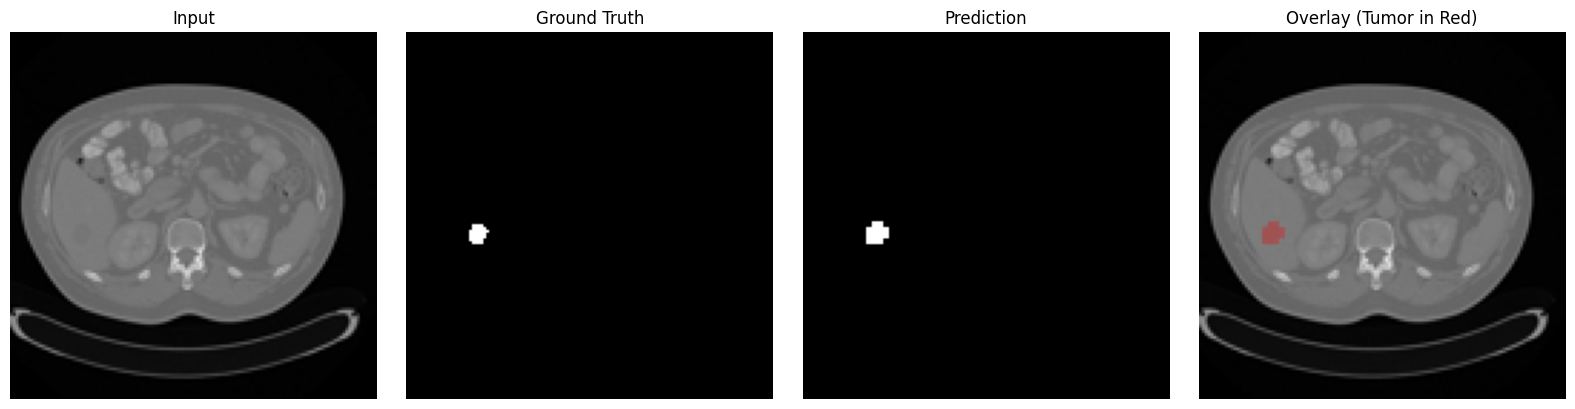

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


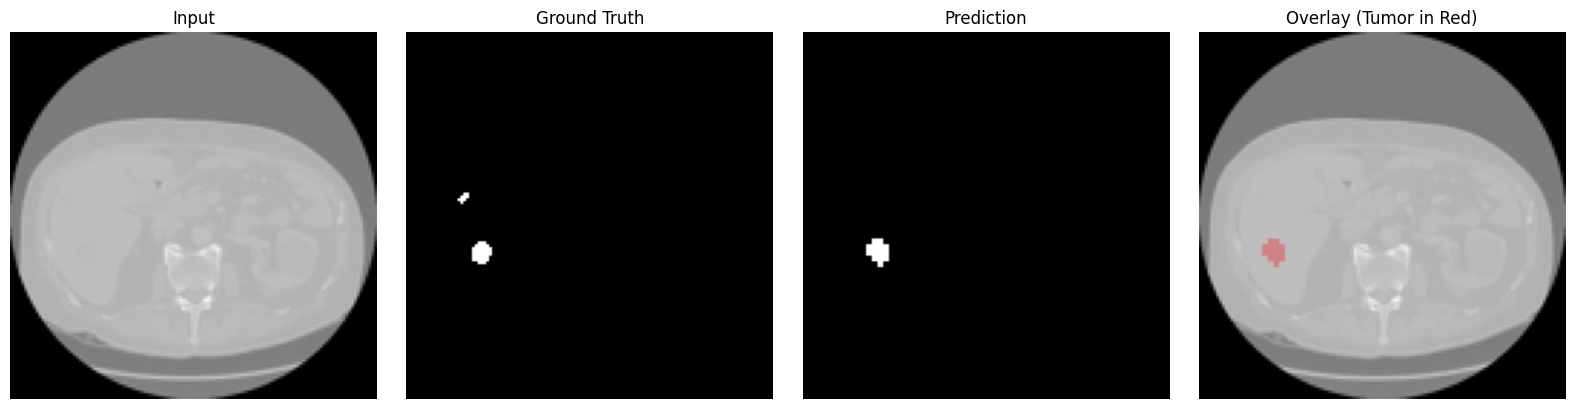

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


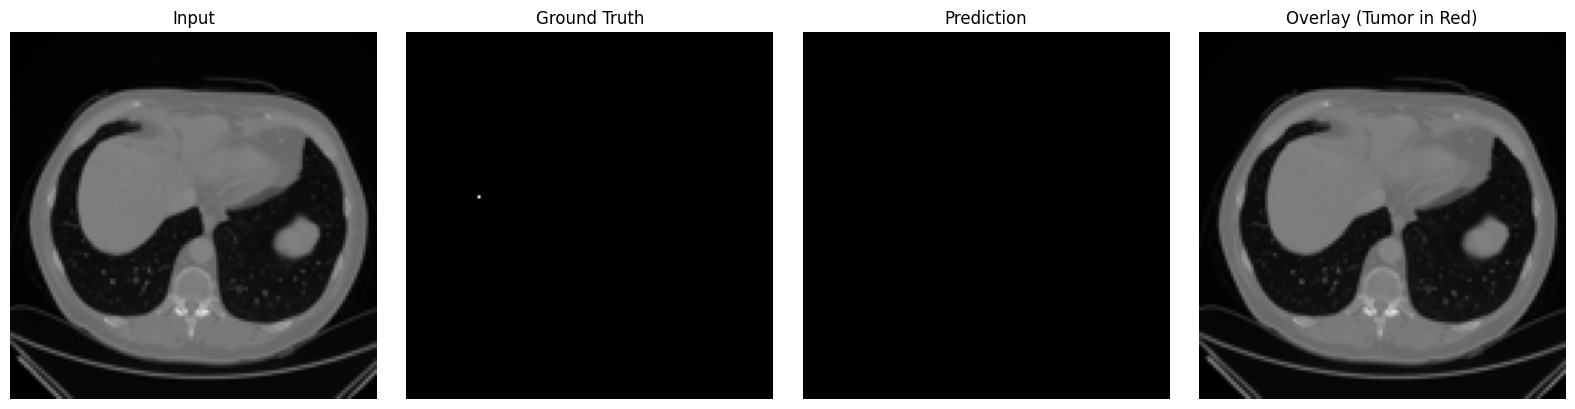

In [30]:
def visualize_tumor_prediction(index):
    img = x_valid_tumor[index]
    true_mask = y_valid_tumor[index].squeeze()
    pred_mask = tumor_model.predict(img[np.newaxis, ...])[0].squeeze()
    pred_mask = (pred_mask > 0.5).astype(np.uint8)

    # Overlay red tumor region
    img_rgb = (img * 255).astype(np.uint8)
    overlay = img_rgb.copy()
    overlay[pred_mask == 1] = [255, 0, 0]  # Red

    blended = cv2.addWeighted(img_rgb, 0.7, overlay, 0.3, 0)

    plt.figure(figsize=(16, 4))
    plt.subplot(1, 4, 1); plt.title("Input"); plt.imshow(img); plt.axis("off")
    plt.subplot(1, 4, 2); plt.title("Ground Truth"); plt.imshow(true_mask, cmap='gray'); plt.axis("off")
    plt.subplot(1, 4, 3); plt.title("Prediction"); plt.imshow(pred_mask, cmap='gray'); plt.axis("off")
    plt.subplot(1, 4, 4); plt.title("Overlay (Tumor in Red)"); plt.imshow(blended); plt.axis("off")
    plt.tight_layout(); plt.show()

# Try on 3 random samples
for i in random.sample(range(len(x_valid_tumor)), 3):
    visualize_tumor_prediction(i)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


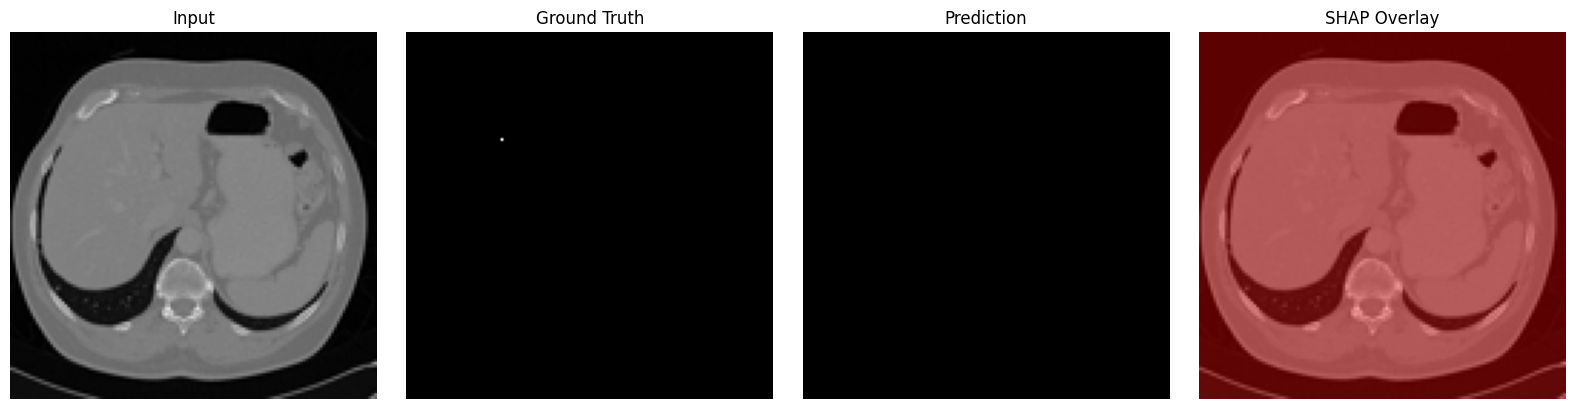

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


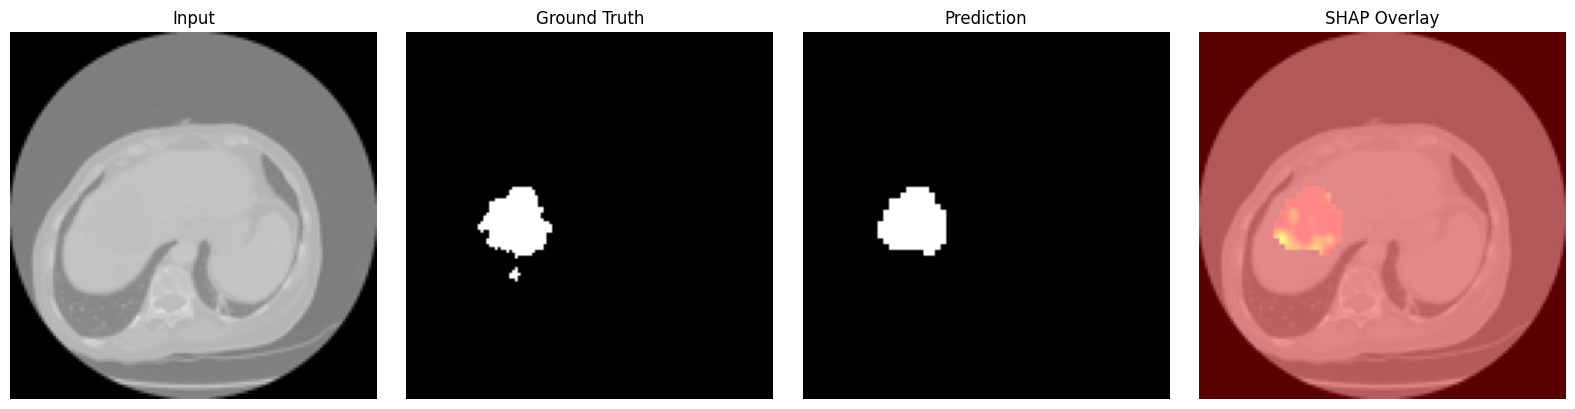

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


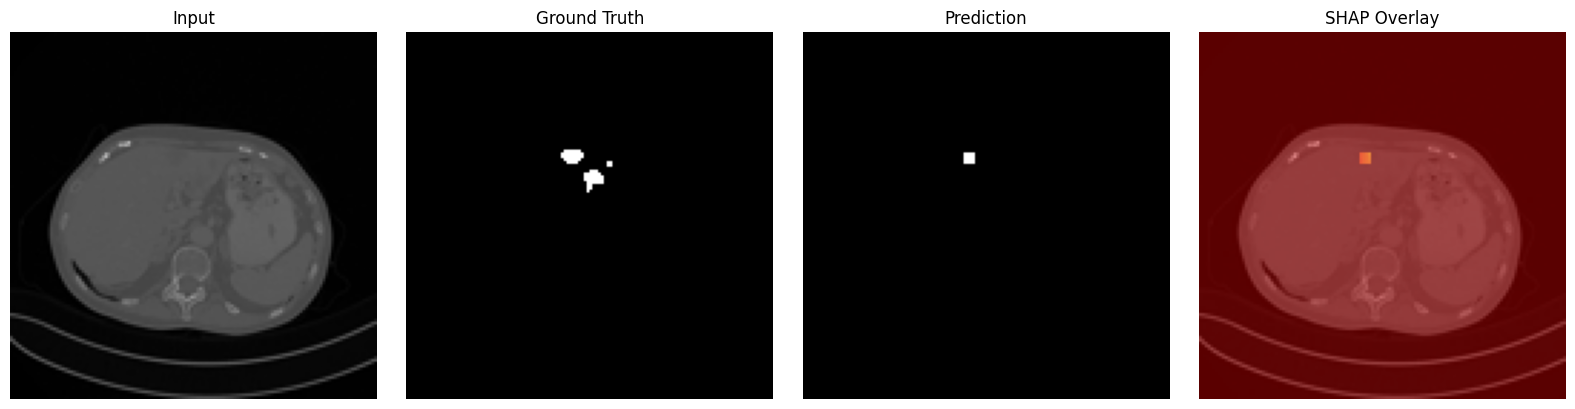

In [33]:
import shap
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
import scipy.ndimage

# 1. Modify model to return a vector output for SHAP
class ReduceMeanLayer(Layer):
    def __init__(self, axis, **kwargs):
        super(ReduceMeanLayer, self).__init__(**kwargs)
        self.axis = axis

    def call(self, inputs):
        return tf.reduce_mean(inputs, axis=self.axis)

def get_shap_ready_model(model):
    input_layer = model.input
    output_layer = model.output
    reduced_output = ReduceMeanLayer(axis=[1, 2])(output_layer)
    return Model(inputs=input_layer, outputs=reduced_output)

def visualize_shap_overlay(index):
    img = x_valid_tumor[index]
    img_input = img[np.newaxis, ...]
    
    pred_mask = tumor_model.predict(img_input)[0].squeeze()
    pred_mask_bin = (pred_mask > 0.5).astype(np.uint8)

    background = np.zeros_like(img_input)
    shap_model = get_shap_ready_model(tumor_model)
    explainer = shap.GradientExplainer(shap_model, background)
    shap_values = explainer.shap_values(img_input)
    
    shap_map = np.abs(shap_values[0].squeeze())
    shap_map = (shap_map - shap_map.min()) / (shap_map.max() - shap_map.min())
    shap_map = scipy.ndimage.gaussian_filter(shap_map, sigma=1.5)
    shap_map = (shap_map * 255).astype(np.uint8)

    tumor_area_shap = cv2.bitwise_and(shap_map, shap_map, mask=pred_mask_bin.astype(np.uint8))

    img_rgb = (img * 255).astype(np.uint8)
    shap_colored = cv2.applyColorMap(tumor_area_shap, cv2.COLORMAP_JET)
    blended = cv2.addWeighted(img_rgb, 0.7, shap_colored, 0.7, 0)

    plt.figure(figsize=(16, 4))
    plt.subplot(1, 4, 1); plt.title("Input"); plt.imshow(img); plt.axis("off")
    plt.subplot(1, 4, 2); plt.title("Ground Truth"); plt.imshow(y_valid_tumor[index].squeeze(), cmap='gray'); plt.axis("off")
    plt.subplot(1, 4, 3); plt.title("Prediction"); plt.imshow(pred_mask_bin, cmap='gray'); plt.axis("off")
    plt.subplot(1, 4, 4); plt.title("SHAP Overlay"); plt.imshow(blended); plt.axis("off")
    plt.tight_layout(); plt.show()

for i in random.sample(range(len(x_valid_tumor)), 3):
    visualize_shap_overlay(i)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


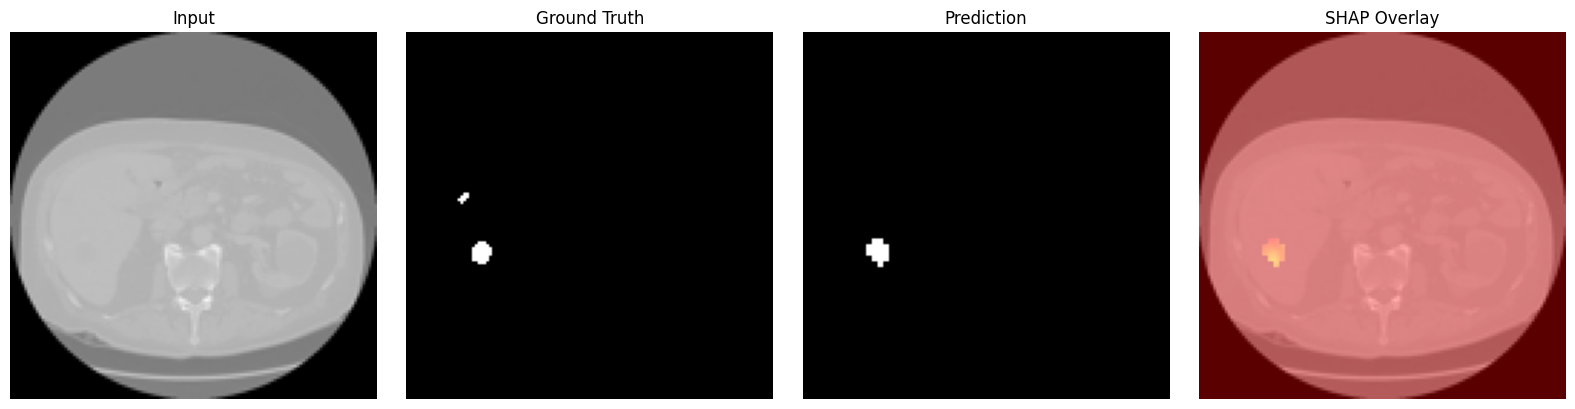

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


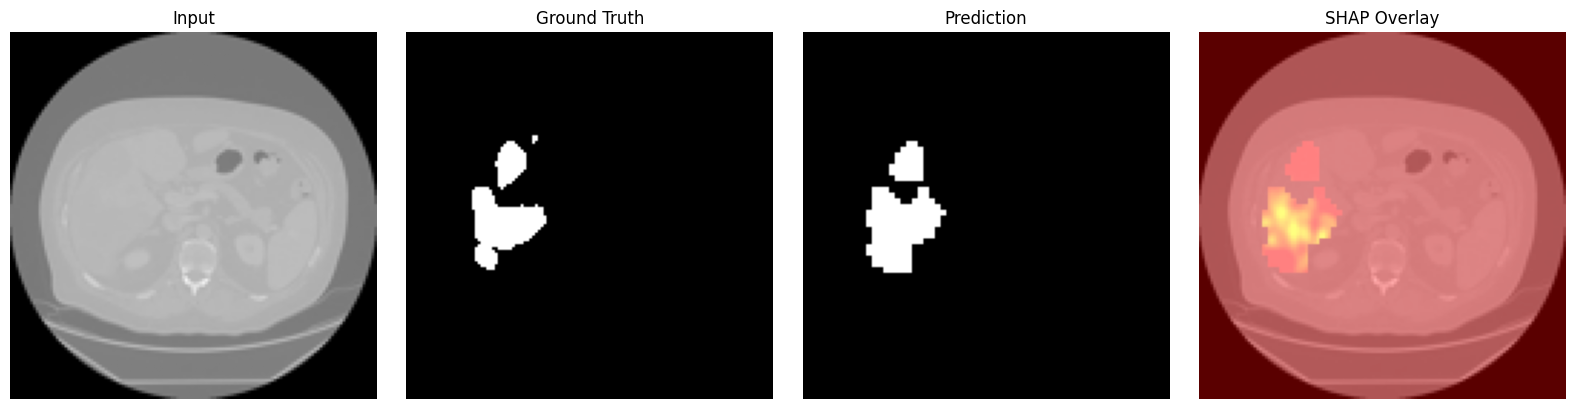

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


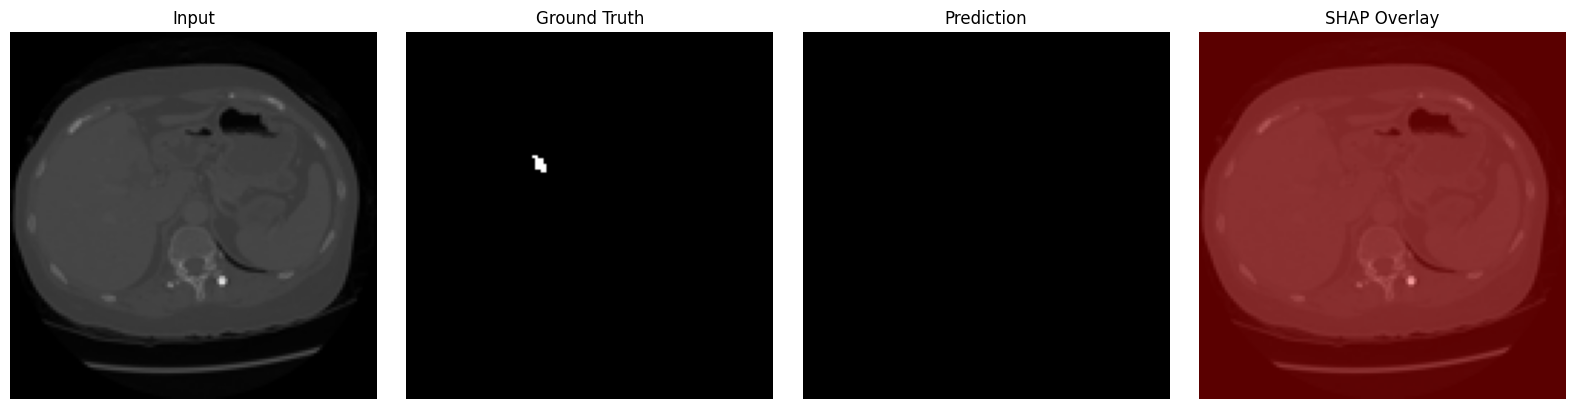

In [34]:
for i in random.sample(range(len(x_valid_tumor)), 3):
    visualize_shap_overlay(i)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


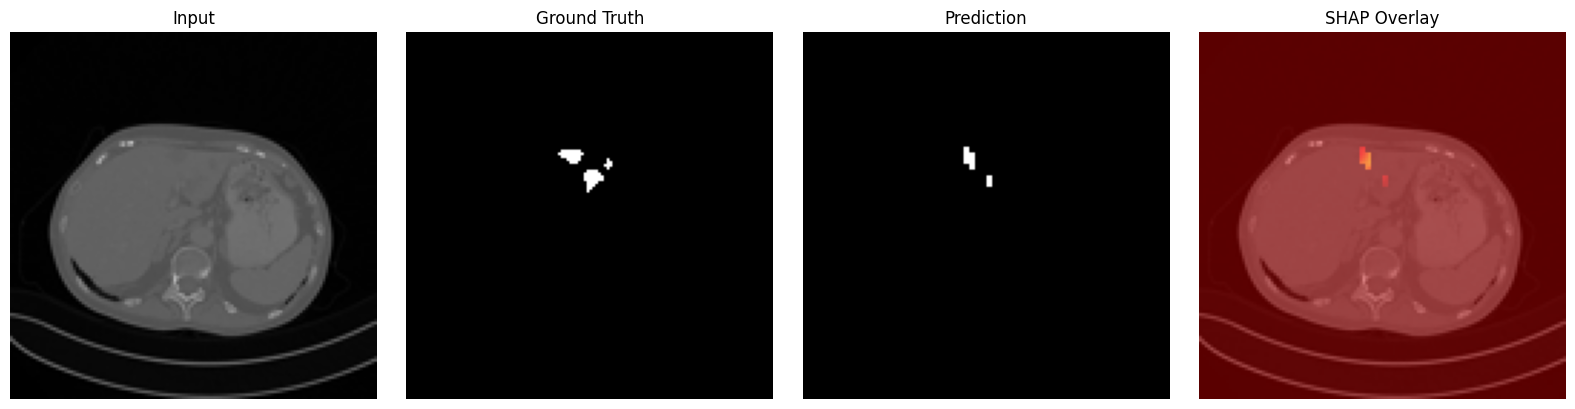

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


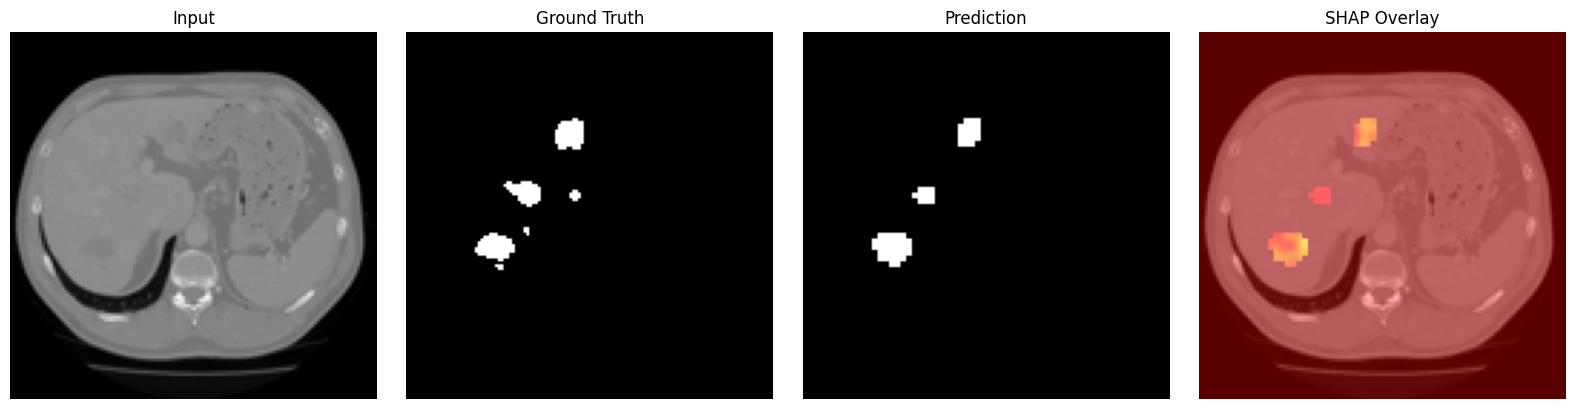

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


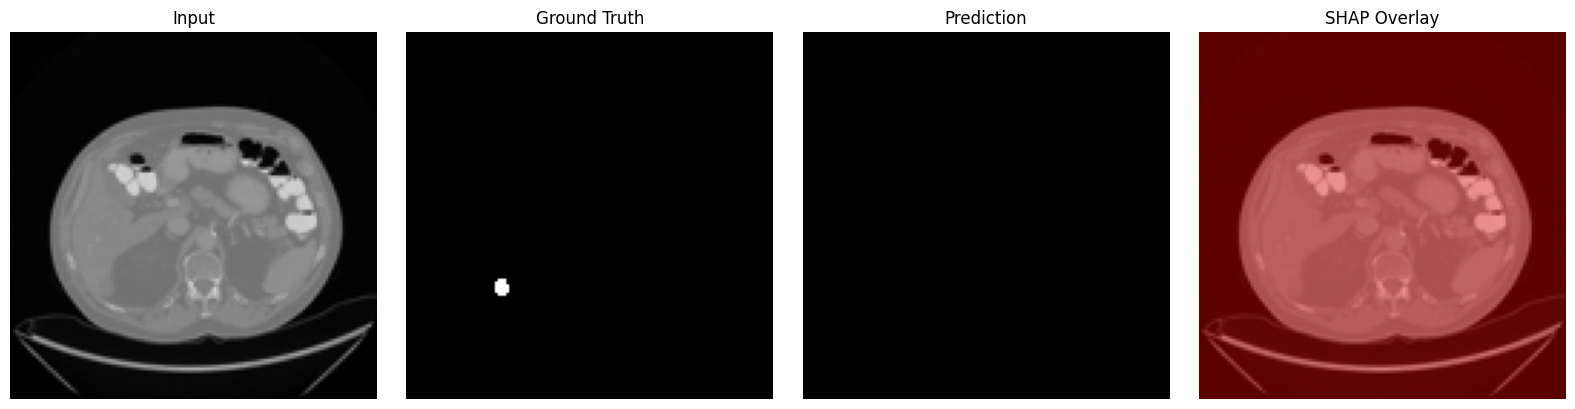

In [35]:
for i in random.sample(range(len(x_valid_tumor)), 3):
    visualize_shap_overlay(i)